## Malicious Url Detection

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import re
from tld import get_tld

In [2]:
df = pd.read_csv('malicious_phish.csv')
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64


<AxesSubplot:xlabel='type', ylabel='count'>

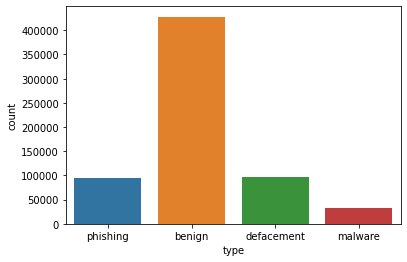

In [3]:
print(df.type.value_counts())
sns.countplot(x="type", data = df)

### Feature Engineering

Check if the url contain IP address (also in hexadecimal form)

0    643898
1      7293
Name: is_ip, dtype: int64


<AxesSubplot:xlabel='is_ip', ylabel='count'>

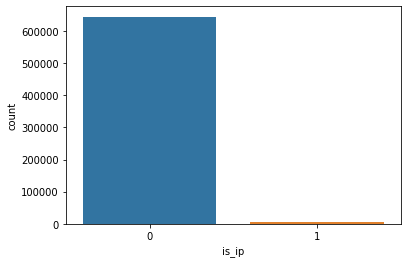

In [4]:
def have_ip_address(url):
  match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6

  return 1 if match else 0
  
df['is_ip'] = df['url'].apply(lambda i: have_ip_address(i))
print(df['is_ip'].value_counts())
sns.countplot(x = 'is_ip', data=df)


If url are able to parse by the parser make it normal(1) else abnormal url(0)

In [5]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)

    return 1 if match else 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

Calculate the lenght of all url

In [6]:
df['url_len'] = df['url'].apply(lambda x: len(str(x)))

Calculate the count of special character in url

In [7]:
features = ['@','?','-','=','.','#','%','+','$','!','*',',','www', "https", "http"]

for feature in features:
  df[feature] = df['url'].apply(lambda x: x.count(feature))

df.head()

,url,type,is_ip,abnormal_url,url_len,@,?,-,=,.,#,%,+,$,!,*,",",www,https,http
0,br-icloud.com.br,phishing,0,0,16,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,35,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,31,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,88,0,1,1,4,3,0,0,0,0,0,0,0,1,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,235,0,1,1,3,2,0,0,0,0,0,0,0,0,0,1


Search for redirects, directories in urls paths

In [8]:
def no_of_redirects(url):
  parse_object = urlparse(url).path
  return str(parse_object).count('//')

def no_of_dir(url):
  parse_object = urlparse(url).path
  return str(parse_object).count('/')

df['redirects'] = df['url'].apply(lambda x: no_of_redirects(x))
df['dirs'] = df['url'].apply(lambda x: no_of_dir(x))

Search for the url shortening service in url

0    611436
1     39755
Name: short_url, dtype: int64


<AxesSubplot:xlabel='short_url', ylabel='count'>

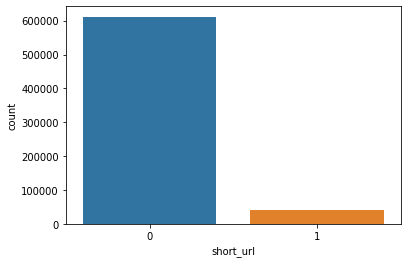

In [9]:
def sortening_service(url):
  match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
  return 1 if match else 0

df['short_url'] = df['url'].apply(lambda x: sortening_service(x))

print(df['short_url'].value_counts())
sns.countplot(x = 'short_url', data=df)

Extract features from Hostname

In [10]:
df['hostname_length'] = df['url'].apply(lambda x: len(urlparse(x).netloc))

Search for the supicious keywords such as payment, login, bank, etc. 

0    607818
1     43373
Name: suspicious, dtype: int64


<AxesSubplot:xlabel='suspicious', ylabel='count'>

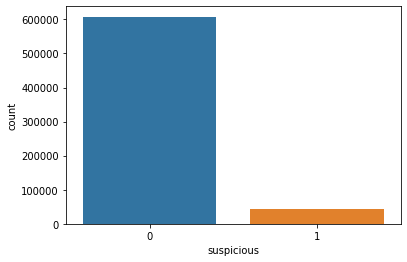

In [11]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    return 1 if match else 0

df['suspicious'] = df['url'].apply(lambda x: suspicious_words(x))

print(df['suspicious'].value_counts())
sns.countplot(x = 'suspicious', data=df)

Extract top level domain length

In [12]:
def get_tld_length(url):
  _tld = get_tld(url,fail_silently=True)

  if _tld:
    return int(len(str(_tld)))
  return 0

df['tld_length'] = df['url'].apply(lambda x: get_tld_length(x))

### Preparing data for training


In [13]:
from sklearn.preprocessing import LabelEncoder

lb_obj = LabelEncoder()
df['label_type'] = lb_obj.fit_transform(df['type'])
df['label_type'].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: label_type, dtype: int64

In [14]:
df.columns

Index(['url', 'type', 'is_ip', 'abnormal_url', 'url_len', '@', '?', '-', '=',
       '.', '#', '%', '+', '$', '!', '*', ',', 'www', 'https', 'http',
       'redirects', 'dirs', 'short_url', 'hostname_length', 'suspicious',
       'tld_length', 'label_type'],
      dtype='object')

In [15]:
X = df.drop(['url', 'type', 'label_type'], axis = 1)
Y = df['label_type']

Spliting the data in Train and Test

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

Test Accuracy : 94.27897941476824%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     85565
           1       0.92      0.97      0.95     19319
           2       0.94      0.90      0.92      6550
           3       0.87      0.76      0.81     18805

    accuracy                           0.94    130239
   macro avg       0.92      0.91      0.91    130239
weighted avg       0.94      0.94      0.94    130239



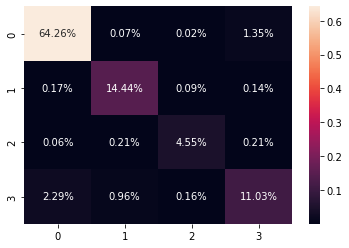

In [20]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier

_model = KNeighborsClassifier()
_model.fit(X_train, Y_train)
pred = _model.predict(X_test)
acc = accuracy_score(pred,Y_test)

print(f'Test Accuracy : {acc*100}%')
print(classification_report(Y_test, pred))
cf_matrix = confusion_matrix(Y_test, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()
